# ViT working on Satori

The goal of this notebook is to get a ViT model training and running on Satori architecture. Once everything works in this notebook, the ViT code will be integrated into the master_ifcb_classifier 

I will be using as much of other people's code as possible. References will be in this bullet list:
- currently copying from Deep Learning homework (https://colab.research.google.com/drive/1jbiPCM6R12-U89wZ7jBBg55UkDyafv8j#scrollTo=d90ecba6)

In [1]:
import torch
import torch.nn as nn
from typing import Tuple, Union, Optional, List
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim


/home/birdy/.conda/envs/cv-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ViT Architecture

In [2]:
class AttentionHead(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim: the dimension of the input
        # n_hidden: the dimension of the keys, queries, and values

        super().__init__()

        self.W_K = nn.Linear(dim, n_hidden) # W_K weight matrix
        self.W_Q = nn.Linear(dim, n_hidden) # W_Q weight matrix
        self.W_V = nn.Linear(dim, n_hidden) # W_V weight matrix
        self.n_hidden = n_hidden

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing self-attention on x. shape: (Batch x Num_tokens x n_hidden)
        # alpha            the attention weights (after softmax). shape: (B x T x T)
        #

        out, alpha = None, None
        # TODO: Compute self attention on x.
        #       (1) First project x to the query Q, key K, value V.
        #       (2) Then compute the attention weights alpha as:
        #                  alpha = softmax(QK^T/sqrt(n_hidden))
        #           Make sure to take into account attn_mask such that token i does not attend on token
        #           j if attn_mask[b, i, j] == 0. (Hint, in such a case, what value should you set the weight
        #           to before the softmax so that after the softmax the value is 0?)
        #       (3) The output is a linear combination of the values (weighted by the alphas):
        #                  out = alpha V
        #       (4) return the output and the alpha after the softmax

        # ======= Answer START ========
        # First project x to the query Q, key K, value V.
        Q = torch.matmul(x, self.W_Q.weight.t())
        K = torch.matmul(x, self.W_K.weight.t())
        V = torch.matmul(x, self.W_V.weight.t())

        # Then compute the attention weights alpha as alpha = softmax(QK^T/sqrt(n_hidden))
        temp = torch.matmul(Q,K.transpose(1,2))/np.sqrt(self.n_hidden)

        # take into account attn_mask such that token i does not attend on token j if attn_mask[b, i, j] == 0.
        if attn_mask != None:
          temp = temp.masked_fill(attn_mask==0, float("-inf"))

        alpha = torch.softmax(temp, -1)

        # The output is a linear combination of the values (weighted by the alphas):
        attn_output = torch.matmul(alpha, V)
        # ======= Answer  END ========

        return attn_output, alpha


In [3]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, dim: int, n_hidden: int, num_heads: int):
        # dim: the dimension of the input
        # n_hidden: the hidden dimenstion for the attention layer
        # num_heads: the number of attention heads
        super().__init__()

        # TODO: set up your parameters for multi-head attention. You should initialize
        #       num_heads attention heads (see nn.ModuleList) as well as a linear layer
        #       that projects the concatenated outputs of each head into dim
        #       (what size should this linear layer be?)
        # ======= Answer START ========
        self.heads = nn.ModuleList([AttentionHead(dim, n_hidden=n_hidden)]*num_heads)
        self.W_O = nn.Linear(n_hidden*num_heads, dim)
        self.n_hidden = n_hidden
        # ======= Answer  END ========

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing multi-headed self-attention on x.
        #                  shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_output, attn_alphas = None, None

        # TODO: Compute multi-headed attention. Loop through each of your attention heads
        #       and collect the outputs. Concatenate them together along the hidden dimension,
        #       and then project them back into the output dimension (dim). Return both
        #       the final attention outputs as well as the alphas from each head.
        # ======= Answer START ========
        outputs = []
        alphas = []

        for head in self.heads:
          attn_output, alpha = head.forward(x, attn_mask)
          outputs.append(attn_output)
          alphas.append(alpha)

        outputs = torch.cat(outputs, 2)
        attn_alphas = torch.stack(alphas, 1)
        attn_output = torch.matmul(outputs, self.W_O.weight.t())
        # ======= Answer END ==========
        return attn_output, attn_alphas

In [4]:
# these are already implemented for you!

class FFN(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim       the dimension of the input
        # n_hidden  the width of the linear layer

        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, dim),
        )

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        # x         the input. shape: (B x T x dim)

        # Outputs:
        # out       the output of the feed-forward network: (B x T x dim)
        return self.net(x)

class AttentionResidual(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        super().__init__()
        self.attn = MultiHeadedAttention(dim, attn_dim, num_heads)
        self.ffn = FFN(dim, mlp_dim)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_out, alphas = self.attn(x=x, attn_mask=attn_mask)
        x = attn_out + x
        x = self.ffn(x) + x
        return x, alphas

In [5]:
class Transformer(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        # num_layers the number of attention layers.
        super().__init__()

        # TODO: set up the parameters for the transformer!
        #       You should set up num_layers of AttentionResiduals
        #       nn.ModuleList will be helpful here.
        # ======= Answer START ========
        self.net = nn.ModuleList([AttentionResidual(dim, attn_dim, mlp_dim, num_heads)]*num_layers)
        # ======= Answer END ==========

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor, return_attn=False)-> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. Pass this to each of the AttentionResidual layers!
        #                  shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      If return_attn is False, return None. Otherwise return the attention weights
        #                  of each of each of the attention heads for each of the layers.
        #                  shape: (B x Num_layers x Num_heads x T x T)

        output, collected_attns = None, None

        # TODO: Implement the transformer forward pass! Pass the input successively through each of the
        # AttentionResidual layers. If return_attn is True, collect the alphas along the way.

        # ======= Answer START ========
        if return_attn:
          collected_attns = []
        for layer in self.net:
          x, alphas = layer.forward(x, attn_mask)
          if return_attn:
            collected_attns.append(alphas)
        output = x
        if return_attn:
          collected_attns = torch.stack(collected_attns, 1)
        # ======= Answer END ==========
        return output, collected_attns

In [6]:
def perform_transformer_test_cases():
    num_tokens = 100
    batch_size = 10
    dim = 64
    num_layers = 4
    num_heads = 2
    dummy_model = Transformer(dim=dim, attn_dim=32, mlp_dim=dim, num_heads=num_heads, num_layers=num_layers).cuda()

    inp = torch.randn(batch_size, num_tokens, dim).cuda()

    # test case 1 regular forward pass
    print("Test Case 1")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None)
        assert alpha is None
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"

    # test case 2 collect attentions
    print("Test Case 2")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None, return_attn=True)
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"
        assert alpha.shape == (batch_size, num_layers, num_heads, num_tokens, num_tokens), f"wrong alpha shape {alpha.shape}. Expected {(batch_size, num_layers, num_heads, num_tokens, num_tokens)}"

    # test case 3 with attention mask
    attn_mask = torch.zeros(batch_size, num_tokens, num_tokens).cuda()
    attn_mask[:, torch.arange(num_tokens), torch.arange(num_tokens)] = 1
    attn_mask[:, torch.arange(num_tokens)[1:], torch.arange(num_tokens)[:-1]] = 1

    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=attn_mask, return_attn=True)
#         print("Attention mask pattern", attn_mask[0])
#         print("Alpha pattern", alpha[0, 0, 0])
        assert torch.all(alpha.permute(1, 2, 0, 3, 4)[:, :, attn_mask == 0] == 0).item()

perform_transformer_test_cases()

Test Case 1
Test Case 2


In [7]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size: int, patch_size: int, nin: int, nout: int):
        # img_size       the width and height of the image. you can assume that
        #                the images will be square
        # patch_size     the width of each square patch. You can assume that
        #                img_size is divisible by patch_size
        # nin            the number of input channels - color channels?
        # nout           the number of output channels - ? embed size?

        super().__init__()
        assert img_size % patch_size == 0

        self.img_size = img_size
        self.num_patches = (img_size // patch_size)**2

        # TODO Set up parameters for the Patch Embedding
        # ======= Answer START ========
        self.patch_size = patch_size
        self.nout = nout
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels = nin, out_channels = nout, kernel_size=patch_size, stride=patch_size),
        )
        # ======= Answer END ==========

    def forward(self, x: torch.Tensor):
        # x        the input image. shape: (B, nin, Height, Width)
        #
        # Output
        # out      the patch embeddings for the input. shape: (B, num_patches, nout)


        # TODO: Implement the patch embedding. You want to split up the image into
        # square patches of the given patch size. Then each patch_size x patch_size
        # square should be linearly projected into an embedding of size nout.
        #
        # Hint: Take a look at nn.Conv2d. How can this be used to perform the
        #       patch embedding?
        out = None

        # ======= Answer START ========
        out = self.projection(x)
        # Rearrange('b e (h) (w) -> b (h w) e')
        out = out.reshape([x.shape[0], self.num_patches, self.nout])
        # ======= Answer END ==========

        return out

In [8]:
class VisionTransformer(nn.Module):
    def __init__(self, n_channels: int, nout: int, img_size: int, patch_size: int, dim: int, attn_dim: int,
                 mlp_dim: int, num_heads: int, num_layers: int):
        # n_channels       number of input image channels
        # nout             desired output dimension
        # img_size         width of the square image
        # patch_size       width of the square patch
        # dim              embedding dimension
        # attn_dim         the hidden dimension of the attention layer
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, nin=n_channels, nout=dim)
        self.pos_E = nn.Embedding((img_size//patch_size)**2, dim) # positional embedding matrix

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim)) # learned class embedding
        self.transformer = Transformer(
            dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=num_heads, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, nout)
        )

    def forward(self, img: torch.Tensor, return_attn=False) ->Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # img          the input image. shape: (B, nin, img_size, img_size)
        # return_attn  whether to return the attention alphas
        #
        # Outputs
        # out          the output of the vision transformer. shape: (B, nout)
        # alphas       the attention weights for all heads and layers. None if return_attn is False, otherwise
        #              shape: (B, num_layers, num_heads, num_patches + 1, num_patches + 1)

        # generate embeddings
        embs = self.patch_embed(img) # patch embedding
        B, T, _ = embs.shape
        pos_ids = torch.arange(T).expand(B, -1).to(embs.device)
        embs += self.pos_E(pos_ids) # positional embedding

        cls_token = self.cls_token.expand(len(embs), -1, -1)
        x = torch.cat([cls_token, embs], dim=1)

        x, alphas = self.transformer(x, attn_mask=None, return_attn=return_attn)
        out = self.head(x)[:, 0]
        return out, alphas



In [9]:

# a utility for calculating running average
class AverageMeter():
    def __init__(self):
        self.num = 0
        self.tot = 0

    def update(self, val: float, sz: float):
        self.num += val*sz
        self.tot += sz

    def calculate(self) -> float:
        return self.num/self.tot

# Training and Testing w/ CIFAR10

In [10]:
# set up the dataset and dataloader

MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2470, 0.2435, 0.2616]
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])
inv_transform = transforms.Compose([
    transforms.Normalize(
        mean = [ 0., 0., 0. ],
        std = 1/np.array(STD)),
    transforms.Normalize(
        mean = -np.array(MEAN),
        std = [ 1., 1., 1. ]),
    transforms.ToPILImage(),
])


train_dataset = torchvision.datasets.CIFAR10(train=True, root='data', transform=img_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10(train=False, root='data', transform=img_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)

Files already downloaded and verified


In [12]:
# set up the model and optimizer

import torch.optim as optim

model = VisionTransformer(n_channels=3, nout=10, img_size=32, patch_size=4,
                          dim=128, attn_dim=64, mlp_dim=128, num_heads=3, num_layers=6).cuda()

criterion = nn.CrossEntropyLoss()


NUM_EPOCHS = 100
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)



In [13]:
def evaluate_cifar_model(model, criterion, val_loader):
    is_train = model.training
    model.eval()
    with torch.no_grad():
        loss_meter, acc_meter = AverageMeter(), AverageMeter()
        for img, labels in val_loader:
            img, labels = img.cuda(), labels.cuda()
            outputs, _ = model(img)
            loss_meter.update(criterion(outputs, labels).item(), len(img))
            acc = (outputs.argmax(-1) == labels).float().mean().item()
            acc_meter.update(acc, len(img))
    model.train(is_train)
    return loss_meter.calculate(), acc_meter.calculate()

In [14]:
# train the model
import tqdm
for epoch in range(NUM_EPOCHS):  #
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    for img, labels in tqdm.tqdm(train_dataloader):
        img, labels = img.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs, _ = model(img)
        loss = criterion(outputs, labels)
        loss_meter.update(loss.item(), len(img))
        acc = (outputs.argmax(-1) == labels).float().mean().item()
        acc_meter.update(acc, len(img))
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Train Epoch: {epoch}, Loss: {loss_meter.calculate()}, Acc: {acc_meter.calculate()}")
    if epoch % 10 == 0:
        val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
        print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")

val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")
print('Finished Training')

100%|██████████| 196/196 [00:18<00:00, 10.87it/s]

Train Epoch: 0, Loss: 1.7360810871505736, Acc: 0.3744800000190735


Val Epoch: 0, Loss: 1.5102790382385254, Acc: 0.4587


100%|██████████| 196/196 [00:10<00:00, 18.82it/s]


Train Epoch: 1, Loss: 1.4749318881988525, Acc: 0.47291999999046325


100%|██████████| 196/196 [00:10<00:00, 18.69it/s]


Train Epoch: 2, Loss: 1.373163929977417, Acc: 0.5113799999904632


100%|██████████| 196/196 [00:10<00:00, 18.60it/s]


Train Epoch: 3, Loss: 1.2988834776306153, Acc: 0.5361400000572205


100%|██████████| 196/196 [00:10<00:00, 18.60it/s]


Train Epoch: 4, Loss: 1.2419255861282348, Acc: 0.559100000038147


100%|██████████| 196/196 [00:10<00:00, 18.82it/s]


Train Epoch: 5, Loss: 1.1904099437713622, Acc: 0.575660000038147


100%|██████████| 196/196 [00:10<00:00, 18.81it/s]


Train Epoch: 6, Loss: 1.1571373138427734, Acc: 0.5878200000190735


100%|██████████| 196/196 [00:10<00:00, 18.85it/s]


Train Epoch: 7, Loss: 1.1606472498703002, Acc: 0.58544


100%|██████████| 196/196 [00:10<00:00, 18.61it/s]


Train Epoch: 8, Loss: 1.094553119392395, Acc: 0.6110999999809266


100%|██████████| 196/196 [00:10<00:00, 18.59it/s]


Train Epoch: 9, Loss: 1.061771543598175, Acc: 0.6203000000190735


100%|██████████| 196/196 [00:10<00:00, 18.77it/s]

Train Epoch: 10, Loss: 1.0312255288505554, Acc: 0.6330800000190735


Val Epoch: 10, Loss: 1.2433982273101807, Acc: 0.563


100%|██████████| 196/196 [00:10<00:00, 18.88it/s]


Train Epoch: 11, Loss: 1.0531886195373534, Acc: 0.6233599999809265


100%|██████████| 196/196 [00:10<00:00, 18.93it/s]


Train Epoch: 12, Loss: 0.9798170141601562, Acc: 0.65238


100%|██████████| 196/196 [00:10<00:00, 18.41it/s]


Train Epoch: 13, Loss: 0.9478683908081055, Acc: 0.663340000038147


100%|██████████| 196/196 [00:10<00:00, 18.80it/s]


Train Epoch: 14, Loss: 2.29164410736084, Acc: 0.13200000001430512


100%|██████████| 196/196 [00:10<00:00, 18.72it/s]


Train Epoch: 15, Loss: 2.305662038269043, Acc: 0.10512000000238418


100%|██████████| 196/196 [00:10<00:00, 18.79it/s]


Train Epoch: 16, Loss: 2.3017796621704103, Acc: 0.10598000000953674


100%|██████████| 196/196 [00:10<00:00, 18.46it/s]


Train Epoch: 17, Loss: 2.308221680755615, Acc: 0.10680000000238418


100%|██████████| 196/196 [00:10<00:00, 18.51it/s]


Train Epoch: 18, Loss: 2.2995930306243895, Acc: 0.11374000000476837


100%|██████████| 196/196 [00:10<00:00, 18.66it/s]


Train Epoch: 19, Loss: 2.299811332168579, Acc: 0.12306


100%|██████████| 196/196 [00:10<00:00, 18.67it/s]

Train Epoch: 20, Loss: 2.298435726699829, Acc: 0.1195


Val Epoch: 20, Loss: 2.2853541477203367, Acc: 0.1472


100%|██████████| 196/196 [00:10<00:00, 18.74it/s]


Train Epoch: 21, Loss: 2.2849179445648193, Acc: 0.13118


100%|██████████| 196/196 [00:10<00:00, 18.59it/s]


Train Epoch: 22, Loss: 2.282843515853882, Acc: 0.13386000000715256


100%|██████████| 196/196 [00:10<00:00, 18.63it/s]


Train Epoch: 23, Loss: 2.2984779766082766, Acc: 0.11682000000715256


100%|██████████| 196/196 [00:10<00:00, 18.59it/s]


Train Epoch: 24, Loss: 2.2865295835876465, Acc: 0.13248000000715257


100%|██████████| 196/196 [00:10<00:00, 18.74it/s]


Train Epoch: 25, Loss: 2.3029406009674074, Acc: 0.12236000001430511


100%|██████████| 196/196 [00:10<00:00, 18.67it/s]


Train Epoch: 26, Loss: 2.2982129136657714, Acc: 0.12046000000715255


100%|██████████| 196/196 [00:10<00:00, 18.61it/s]


Train Epoch: 27, Loss: 2.299991404953003, Acc: 0.11860000000715255


100%|██████████| 196/196 [00:10<00:00, 18.73it/s]


Train Epoch: 28, Loss: 2.2766525968933107, Acc: 0.13684000000953675


100%|██████████| 196/196 [00:10<00:00, 18.69it/s]


Train Epoch: 29, Loss: 2.3086236506652833, Acc: 0.11038000000476837


100%|██████████| 196/196 [00:10<00:00, 18.49it/s]

Train Epoch: 30, Loss: 2.311433843002319, Acc: 0.11148000000476838


Val Epoch: 30, Loss: 2.302173293304443, Acc: 0.1081


100%|██████████| 196/196 [00:10<00:00, 18.68it/s]


Train Epoch: 31, Loss: 2.3043723461151124, Acc: 0.10824000000238418


100%|██████████| 196/196 [00:10<00:00, 18.61it/s]


Train Epoch: 32, Loss: 2.29904193649292, Acc: 0.1124


100%|██████████| 196/196 [00:10<00:00, 18.71it/s]


Train Epoch: 33, Loss: 2.300428465881348, Acc: 0.11192000000476837


100%|██████████| 196/196 [00:10<00:00, 18.72it/s]


Train Epoch: 34, Loss: 2.30206118888855, Acc: 0.10776000000476837


100%|██████████| 196/196 [00:10<00:00, 18.58it/s]


Train Epoch: 35, Loss: 2.2984151988220214, Acc: 0.11370000000715255


100%|██████████| 196/196 [00:10<00:00, 18.76it/s]


Train Epoch: 36, Loss: 2.284206725540161, Acc: 0.13222000001430512


100%|██████████| 196/196 [00:10<00:00, 18.68it/s]


Train Epoch: 37, Loss: 2.2859817710876467, Acc: 0.12959999999523164


100%|██████████| 196/196 [00:10<00:00, 18.66it/s]


Train Epoch: 38, Loss: 2.290014093093872, Acc: 0.12750000000476838


100%|██████████| 196/196 [00:10<00:00, 18.78it/s]


Train Epoch: 39, Loss: 2.2964499522399904, Acc: 0.11287999999761582


100%|██████████| 196/196 [00:10<00:00, 18.43it/s]

Train Epoch: 40, Loss: 2.2952667624664307, Acc: 0.11854000001430512


Val Epoch: 40, Loss: 2.2951974517822267, Acc: 0.1093


100%|██████████| 196/196 [00:10<00:00, 18.55it/s]


Train Epoch: 41, Loss: 2.2948820363616944, Acc: 0.11812000000715256


100%|██████████| 196/196 [00:10<00:00, 18.55it/s]


Train Epoch: 42, Loss: 2.2996790559387206, Acc: 0.11346000000715256


100%|██████████| 196/196 [00:10<00:00, 18.72it/s]


Train Epoch: 43, Loss: 2.300399686508179, Acc: 0.10934000000715256


100%|██████████| 196/196 [00:10<00:00, 18.77it/s]


Train Epoch: 44, Loss: 2.3018237773895263, Acc: 0.10902000000476837


100%|██████████| 196/196 [00:10<00:00, 18.59it/s]


Train Epoch: 45, Loss: 2.2955358500671386, Acc: 0.11768000000238418


100%|██████████| 196/196 [00:10<00:00, 18.71it/s]


Train Epoch: 46, Loss: 2.2950464686584473, Acc: 0.11662000000238419


100%|██████████| 196/196 [00:10<00:00, 18.51it/s]


Train Epoch: 47, Loss: 2.2872448136901857, Acc: 0.12872000000476838


100%|██████████| 196/196 [00:10<00:00, 18.65it/s]


Train Epoch: 48, Loss: 2.286145498275757, Acc: 0.1272


100%|██████████| 196/196 [00:10<00:00, 18.39it/s]


Train Epoch: 49, Loss: 2.2860226679992675, Acc: 0.13220000000953674


100%|██████████| 196/196 [00:10<00:00, 18.60it/s]

Train Epoch: 50, Loss: 2.285373553543091, Acc: 0.13284000000476837


Val Epoch: 50, Loss: 2.2850142253875734, Acc: 0.1346


100%|██████████| 196/196 [00:10<00:00, 18.23it/s]


Train Epoch: 51, Loss: 2.2851381206512453, Acc: 0.13102000000238417


100%|██████████| 196/196 [00:10<00:00, 18.59it/s]


Train Epoch: 52, Loss: 2.2853252909851074, Acc: 0.13336000001430512


100%|██████████| 196/196 [00:10<00:00, 18.58it/s]


Train Epoch: 53, Loss: 2.28553620010376, Acc: 0.13343999999761583


100%|██████████| 196/196 [00:10<00:00, 18.73it/s]


Train Epoch: 54, Loss: 2.284704485473633, Acc: 0.13374000000238417


100%|██████████| 196/196 [00:10<00:00, 18.75it/s]


Train Epoch: 55, Loss: 2.2850527838897703, Acc: 0.1336000000143051


100%|██████████| 196/196 [00:10<00:00, 18.44it/s]


Train Epoch: 56, Loss: 2.28500916305542, Acc: 0.1326


100%|██████████| 196/196 [00:10<00:00, 18.63it/s]


Train Epoch: 57, Loss: 2.285015517578125, Acc: 0.13422


100%|██████████| 196/196 [00:10<00:00, 18.73it/s]


Train Epoch: 58, Loss: 2.284448709869385, Acc: 0.1315200000143051


100%|██████████| 196/196 [00:10<00:00, 18.45it/s]


Train Epoch: 59, Loss: 2.2843938948822022, Acc: 0.13176000000476837


100%|██████████| 196/196 [00:10<00:00, 18.73it/s]

Train Epoch: 60, Loss: 2.284666485748291, Acc: 0.1346800000023842


Val Epoch: 60, Loss: 2.282994328689575, Acc: 0.1303


100%|██████████| 196/196 [00:10<00:00, 18.66it/s]


Train Epoch: 61, Loss: 2.2840104804992674, Acc: 0.1306999999976158


100%|██████████| 196/196 [00:10<00:00, 18.36it/s]


Train Epoch: 62, Loss: 2.2840244816589355, Acc: 0.1336800000023842


100%|██████████| 196/196 [00:10<00:00, 18.71it/s]


Train Epoch: 63, Loss: 2.284267661743164, Acc: 0.132


100%|██████████| 196/196 [00:10<00:00, 18.65it/s]


Train Epoch: 64, Loss: 2.2843896112060547, Acc: 0.13056


100%|██████████| 196/196 [00:10<00:00, 18.55it/s]


Train Epoch: 65, Loss: 2.2838390074157715, Acc: 0.13401999999761582


100%|██████████| 196/196 [00:10<00:00, 18.56it/s]


Train Epoch: 66, Loss: 2.2840219469451903, Acc: 0.13538000000476838


100%|██████████| 196/196 [00:10<00:00, 18.72it/s]


Train Epoch: 67, Loss: 2.283694675064087, Acc: 0.13454000000715255


100%|██████████| 196/196 [00:10<00:00, 18.72it/s]


Train Epoch: 68, Loss: 2.2838070893859865, Acc: 0.1361800000143051


100%|██████████| 196/196 [00:10<00:00, 18.63it/s]


Train Epoch: 69, Loss: 2.2833184131622315, Acc: 0.13491999999523163


100%|██████████| 196/196 [00:10<00:00, 18.70it/s]

Train Epoch: 70, Loss: 2.283613144226074, Acc: 0.13390000000476837


Val Epoch: 70, Loss: 2.2824528305053713, Acc: 0.1311


100%|██████████| 196/196 [00:10<00:00, 18.40it/s]


Train Epoch: 71, Loss: 2.283255284805298, Acc: 0.13465999999761583


100%|██████████| 196/196 [00:10<00:00, 18.71it/s]


Train Epoch: 72, Loss: 2.28303085105896, Acc: 0.13350000000476836


100%|██████████| 196/196 [00:10<00:00, 18.65it/s]


Train Epoch: 73, Loss: 2.2833414752197267, Acc: 0.13472000000476836


100%|██████████| 196/196 [00:10<00:00, 18.32it/s]


Train Epoch: 74, Loss: 2.2833870498657225, Acc: 0.13380000000476838


100%|██████████| 196/196 [00:10<00:00, 18.59it/s]


Train Epoch: 75, Loss: 2.2834546491241454, Acc: 0.1343


100%|██████████| 196/196 [00:10<00:00, 18.84it/s]


Train Epoch: 76, Loss: 2.283338583984375, Acc: 0.13492000000953674


100%|██████████| 196/196 [00:10<00:00, 18.69it/s]


Train Epoch: 77, Loss: 2.2831697595977785, Acc: 0.13372


100%|██████████| 196/196 [00:10<00:00, 18.72it/s]


Train Epoch: 78, Loss: 2.2832963793945313, Acc: 0.13644


100%|██████████| 196/196 [00:10<00:00, 18.66it/s]


Train Epoch: 79, Loss: 2.282858510055542, Acc: 0.13422000000953674


100%|██████████| 196/196 [00:10<00:00, 18.58it/s]

Train Epoch: 80, Loss: 2.2829096764373777, Acc: 0.1357000000023842


Val Epoch: 80, Loss: 2.280892468261719, Acc: 0.1347


100%|██████████| 196/196 [00:10<00:00, 18.51it/s]


Train Epoch: 81, Loss: 2.283102577896118, Acc: 0.13562


100%|██████████| 196/196 [00:10<00:00, 18.59it/s]


Train Epoch: 82, Loss: 2.282981783294678, Acc: 0.1364199999976158


100%|██████████| 196/196 [00:10<00:00, 18.53it/s]


Train Epoch: 83, Loss: 2.2830381493377687, Acc: 0.1376399999976158


100%|██████████| 196/196 [00:10<00:00, 18.42it/s]


Train Epoch: 84, Loss: 2.2832194966125487, Acc: 0.13422000001430512


100%|██████████| 196/196 [00:10<00:00, 18.61it/s]


Train Epoch: 85, Loss: 2.2830359344482423, Acc: 0.13633999999523164


100%|██████████| 196/196 [00:10<00:00, 18.67it/s]


Train Epoch: 86, Loss: 2.28282505569458, Acc: 0.13514000001430512


100%|██████████| 196/196 [00:10<00:00, 18.73it/s]


Train Epoch: 87, Loss: 2.2830336223602297, Acc: 0.1366800000143051


100%|██████████| 196/196 [00:10<00:00, 18.58it/s]


Train Epoch: 88, Loss: 2.282862596282959, Acc: 0.1372400000143051


100%|██████████| 196/196 [00:10<00:00, 18.67it/s]


Train Epoch: 89, Loss: 2.283224697570801, Acc: 0.13550000000476836


100%|██████████| 196/196 [00:10<00:00, 18.47it/s]

Train Epoch: 90, Loss: 2.2829603485870362, Acc: 0.13644000000715256


Val Epoch: 90, Loss: 2.2816895343780517, Acc: 0.1341


100%|██████████| 196/196 [00:10<00:00, 18.66it/s]


Train Epoch: 91, Loss: 2.2828311769866945, Acc: 0.1362199999976158


100%|██████████| 196/196 [00:10<00:00, 18.61it/s]


Train Epoch: 92, Loss: 2.2828942594909667, Acc: 0.13724000000715256


100%|██████████| 196/196 [00:10<00:00, 18.63it/s]


Train Epoch: 93, Loss: 2.2829390634155273, Acc: 0.13770000000953675


100%|██████████| 196/196 [00:10<00:00, 18.59it/s]


Train Epoch: 94, Loss: 2.2829725260162355, Acc: 0.13834000000715255


100%|██████████| 196/196 [00:10<00:00, 18.53it/s]


Train Epoch: 95, Loss: 2.2831955434417726, Acc: 0.13816


100%|██████████| 196/196 [00:10<00:00, 18.48it/s]


Train Epoch: 96, Loss: 2.2829542694854736, Acc: 0.13784000000476837


100%|██████████| 196/196 [00:10<00:00, 18.54it/s]


Train Epoch: 97, Loss: 2.282839346923828, Acc: 0.1380400000143051


100%|██████████| 196/196 [00:10<00:00, 18.48it/s]


Train Epoch: 98, Loss: 2.2828545465087893, Acc: 0.13810000000953673


100%|██████████| 196/196 [00:10<00:00, 18.59it/s]

Train Epoch: 99, Loss: 2.282855720214844, Acc: 0.13788000000476838


Val Epoch: 99, Loss: 2.2818898082733154, Acc: 0.1351
Finished Training


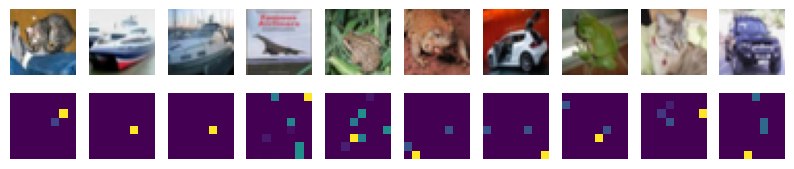

In [15]:
for val_batch in val_dataloader:
    break

model.eval()
with torch.no_grad():
    img, labels = val_batch
    img = img.cuda()
    outputs, attns = model(img, return_attn=True)

fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    flattened_attns = attns.flatten(1,2)[:, :, 0, 1:].mean(1).reshape(-1, 8, 8).cpu().numpy()
    ax[0, i].imshow(inv_transform(img[i]))
    ax[1, i].imshow(flattened_attns[i])
    ax[0, i].axis(False)
    ax[1, i].axis(False)

# Training and Testing with Plankton Data

In [11]:
# using my custom dataloader 
from utils.dataloader import get_dataloaders, save_label_to_idx, CustomDataset
from utils.model_utils import train_model, save_model, generate_unique_model_name

In [12]:
data_dir = "/home/birdy/meng_thesis/data/unsorted_MGL1704_data"
label_path = "/home/birdy/meng_thesis/data/mgl1704_labels.csv"
# Data preparation
dataloaders = get_dataloaders(data_dir, label_path, batch_size=256)
dataloaders

Transforms being applied: [Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None), ToTensor()]


{'train': <torch.utils.data.dataloader.DataLoader at 0x2008ab539540>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x20095181c3a0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x20095181d000>}

In [13]:
# create model 
# num_classes = dataloaders["train"].dataset.num_classes()
model = VisionTransformer(n_channels=3, nout=138, img_size=256, patch_size=32,
                          dim=128, attn_dim=64, mlp_dim=128, num_heads=3, num_layers=6).cuda()

criterion = nn.CrossEntropyLoss()


NUM_EPOCHS = 10
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [16]:
# train the model
import tqdm
NUM_EPOCHS = 50
for epoch in range(NUM_EPOCHS):  #
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    for img, labels in tqdm.tqdm(dataloaders['train']):
        img, labels = img.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs, _ = model(img)
        loss = criterion(outputs, labels)
        loss_meter.update(loss.item(), len(img))
        acc = (outputs.argmax(-1) == labels).float().mean().item()
        acc_meter.update(acc, len(img))
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Train Epoch: {epoch}, Loss: {loss_meter.calculate()}, Acc: {acc_meter.calculate()}")
    if epoch % 10 == 0:
        val_loss, val_acc = evaluate_cifar_model(model, criterion, dataloaders['val'])
        print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")

val_loss, val_acc = evaluate_cifar_model(model, criterion, dataloaders['val'])
print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")
print('Finished Training')

#save the model 
from utils.model_utils import save_model
output_dir = '/home/birdy/meng_thesis/code/master_ifcb_classifier/output'
save_model(model, output_dir, model_name=f"vit_MGL1704_{NUM_EPOCHS}")

100%|██████████| 390/390 [04:17<00:00,  1.51it/s]

Train Epoch: 0, Loss: 3.307667589798952, Acc: 0.20640024038461538


Val Epoch: 0, Loss: 3.744976066594766, Acc: 0.13824008691198644


100%|██████████| 390/390 [04:18<00:00,  1.51it/s]


Train Epoch: 1, Loss: 3.3044716792228894, Acc: 0.2045372596153846


100%|██████████| 390/390 [04:18<00:00,  1.51it/s]


Train Epoch: 2, Loss: 3.299294230876825, Acc: 0.2015925480769231


100%|██████████| 390/390 [04:17<00:00,  1.51it/s]


Train Epoch: 3, Loss: 3.2809208631515503, Acc: 0.2012419871794872


100%|██████████| 390/390 [04:17<00:00,  1.51it/s]


Train Epoch: 4, Loss: 3.2723294637142084, Acc: 0.19904847756410257


100%|██████████| 390/390 [04:18<00:00,  1.51it/s]


Train Epoch: 5, Loss: 3.2358628511428833, Acc: 0.20931490384615384


100%|██████████| 390/390 [04:18<00:00,  1.51it/s]


Train Epoch: 6, Loss: 3.22144349416097, Acc: 0.2069110576923077


100%|██████████| 390/390 [04:19<00:00,  1.50it/s]


Train Epoch: 7, Loss: 3.1937955024914864, Acc: 0.21200921474358975


100%|██████████| 390/390 [04:16<00:00,  1.52it/s]


Train Epoch: 8, Loss: 3.141691338098966, Acc: 0.21728766025641025


100%|██████████| 390/390 [04:18<00:00,  1.51it/s]


Train Epoch: 9, Loss: 3.122473665384146, Acc: 0.22278645833333333


100%|██████████| 390/390 [04:16<00:00,  1.52it/s]

Train Epoch: 10, Loss: 3.0810273537269004, Acc: 0.22906650641025642


Val Epoch: 10, Loss: 3.722373844063615, Acc: 0.1307260546817763


100%|██████████| 390/390 [04:17<00:00,  1.52it/s]


Train Epoch: 11, Loss: 3.057301378861452, Acc: 0.23459535256410258


100%|██████████| 390/390 [04:17<00:00,  1.51it/s]


Train Epoch: 12, Loss: 3.037443576103602, Acc: 0.23931290064102564


100%|██████████| 390/390 [04:16<00:00,  1.52it/s]


Train Epoch: 13, Loss: 4.819811228605417, Acc: 0.06948116987179487


100%|██████████| 390/390 [04:14<00:00,  1.53it/s]


Train Epoch: 14, Loss: 5.315664801230797, Acc: 0.008353365384615384


100%|██████████| 390/390 [04:17<00:00,  1.52it/s]


Train Epoch: 15, Loss: 4.879505699108808, Acc: 0.012540064102564103


100%|██████████| 390/390 [04:15<00:00,  1.53it/s]


Train Epoch: 16, Loss: 4.41158417555002, Acc: 0.06142828525641025


100%|██████████| 390/390 [04:15<00:00,  1.52it/s]


Train Epoch: 17, Loss: 3.593820465528048, Acc: 0.15213341346153847


100%|██████████| 390/390 [04:17<00:00,  1.51it/s]


Train Epoch: 18, Loss: 3.3458266667830636, Acc: 0.19626402243589744


100%|██████████| 390/390 [04:14<00:00,  1.53it/s]


Train Epoch: 19, Loss: 3.2938556854541483, Acc: 0.2029647435897436


100%|██████████| 390/390 [04:17<00:00,  1.51it/s]

Train Epoch: 20, Loss: 3.293255201364175, Acc: 0.21021634615384616


Val Epoch: 20, Loss: 3.8234862818197923, Acc: 0.10869696420037946


100%|██████████| 390/390 [04:15<00:00,  1.53it/s]


Train Epoch: 21, Loss: 3.306183360173152, Acc: 0.20682091346153847


100%|██████████| 390/390 [04:14<00:00,  1.53it/s]


Train Epoch: 22, Loss: 3.214087296143556, Acc: 0.21956129807692307


100%|██████████| 390/390 [04:14<00:00,  1.53it/s]


Train Epoch: 23, Loss: 3.671477089784084, Acc: 0.17286658653846154


100%|██████████| 390/390 [04:16<00:00,  1.52it/s]


Train Epoch: 24, Loss: 3.35861366773263, Acc: 0.18553685897435898


100%|██████████| 390/390 [04:17<00:00,  1.52it/s]


Train Epoch: 25, Loss: 3.1288834700217616, Acc: 0.2278545673076923


100%|██████████| 390/390 [04:15<00:00,  1.52it/s]


Train Epoch: 26, Loss: 3.0848606830988174, Acc: 0.23576722756410257


100%|██████████| 390/390 [04:18<00:00,  1.51it/s]


Train Epoch: 27, Loss: 3.036217009715545, Acc: 0.24328926282051283


100%|██████████| 390/390 [04:17<00:00,  1.52it/s]


Train Epoch: 28, Loss: 2.990244772495368, Acc: 0.2529847756410256


100%|██████████| 390/390 [04:14<00:00,  1.53it/s]


Train Epoch: 29, Loss: 4.719738027377006, Acc: 0.08231169871794872


100%|██████████| 390/390 [04:17<00:00,  1.52it/s]

Train Epoch: 30, Loss: 4.930598781047723, Acc: 0.008193108974358975


Val Epoch: 30, Loss: 5.024842269261333, Acc: 0.00841933731667572


100%|██████████| 390/390 [04:14<00:00,  1.53it/s]


Train Epoch: 31, Loss: 4.927850328347621, Acc: 0.008403445512820512


100%|██████████| 390/390 [04:16<00:00,  1.52it/s]


Train Epoch: 32, Loss: 4.92567398976057, Acc: 0.008413461538461538


100%|██████████| 390/390 [04:27<00:00,  1.46it/s]


Train Epoch: 33, Loss: 4.923239163863353, Acc: 0.007992788461538461


100%|██████████| 390/390 [04:18<00:00,  1.51it/s]


Train Epoch: 34, Loss: 4.920283540089925, Acc: 0.009114583333333334


100%|██████████| 390/390 [04:14<00:00,  1.53it/s]


Train Epoch: 35, Loss: 4.916911397836147, Acc: 0.009375


100%|██████████| 390/390 [04:14<00:00,  1.53it/s]


Train Epoch: 36, Loss: 4.915509677544618, Acc: 0.009184695512820513


100%|██████████| 390/390 [04:16<00:00,  1.52it/s]


Train Epoch: 37, Loss: 4.912756595856104, Acc: 0.009585336538461539


100%|██████████| 390/390 [04:17<00:00,  1.51it/s]


Train Epoch: 38, Loss: 4.910809360406337, Acc: 0.010596955128205129


100%|██████████| 390/390 [04:17<00:00,  1.52it/s]


Train Epoch: 39, Loss: 4.909821359927838, Acc: 0.013912259615384615


100%|██████████| 390/390 [04:17<00:00,  1.52it/s]

Train Epoch: 40, Loss: 4.909702808429033, Acc: 0.014082532051282052


Val Epoch: 40, Loss: 5.012264289236636, Acc: 0.012251795521982333


100%|██████████| 390/390 [04:16<00:00,  1.52it/s]


Train Epoch: 41, Loss: 4.909544526613676, Acc: 0.016025641025641024


100%|██████████| 390/390 [04:17<00:00,  1.51it/s]


Train Epoch: 42, Loss: 4.910664150042412, Acc: 0.013090945512820513


100%|██████████| 390/390 [04:16<00:00,  1.52it/s]


Train Epoch: 43, Loss: 4.912516849468916, Acc: 0.011147836538461539


100%|██████████| 390/390 [04:17<00:00,  1.52it/s]


Train Epoch: 44, Loss: 4.914354978463589, Acc: 0.010046073717948719


100%|██████████| 390/390 [04:15<00:00,  1.53it/s]


Train Epoch: 45, Loss: 4.916754723817874, Acc: 0.00884415064102564


100%|██████████| 390/390 [04:16<00:00,  1.52it/s]


Train Epoch: 46, Loss: 4.914254571229984, Acc: 0.00969551282051282


100%|██████████| 390/390 [04:17<00:00,  1.52it/s]


Train Epoch: 47, Loss: 4.9102242836585415, Acc: 0.010116185897435898


100%|██████████| 390/390 [04:13<00:00,  1.54it/s]


Train Epoch: 48, Loss: 4.906985543324397, Acc: 0.012890625


100%|██████████| 390/390 [04:15<00:00,  1.53it/s]

Train Epoch: 49, Loss: 4.899460077285767, Acc: 0.013141025641025641


Val Epoch: 49, Loss: 5.006300639801145, Acc: 0.007876154264211798
Finished Training


In [15]:
val_loss, val_acc = evaluate_cifar_model(model, criterion, dataloaders['val'])
print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")
print('Finished Training')

#save the model 
from utils.model_utils import save_model
output_dir = '/home/birdy/meng_thesis/code/master_ifcb_classifier/output'
save_model(model, output_dir, model_name="vit_MGL1704")

Val Epoch: 9, Loss: 3.7499814135385514, Acc: 0.1376969038592977
Finished Training
